# Modelling 01

In this notebook I will explore different predictive models.  
First, I will create a baseline model by calculating the average of pickups per zone and per hour.  
After that, I will use some regression models to compare with the baseline model and select the best one.

### 1. [Import dataset and select features](#Import-dataset-and-select-features)

- [Select columns of interest](#Select-columns-of-interest)
- [Separate Input and Output variables](#Separate-Input-and-Output-variables)

### 2. [Split data](#Split-data)

NOTE: Create base model. It will give us the baseline accuracy and and I should try to beat this baseline accuracy using more advanced techniques. This base model could be the average for a specific hour.

# Import dataset and select features

From the cleaned datasets saved from previous notebooks, I will use the one from ``2019`` and will leave the others (``2018`` and ``2017``) in case I need more training data.

In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

### Select columns of interest

According to the conclusion from the notebook ``Data_Analysis_01.ipynb``, I will not use the following columns:

- ``month``
- ``hour``
- ``week``
- ``dayofweek``
- ``isholiday``
- ``LocationID``
- ``precipitation``
- ``pickups``

In [2]:
# Import dataset
df = pd.read_csv('../data/Data_Cleaned_2019_To_Model.csv', sep=',',                 
                 dtype = {"LocationID" : "object"},
                 parse_dates=['datetime'])

# Select columns of interest
df = df[['month', 'hour', 'week', 'dayofweek', 'isholiday', 'LocationID', 'precipitation', 'pickups']]
df.info() # check dtypes
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586920 entries, 0 to 586919
Data columns (total 8 columns):
month            586920 non-null int64
hour             586920 non-null int64
week             586920 non-null int64
dayofweek        586920 non-null int64
isholiday        586920 non-null int64
LocationID       586920 non-null object
precipitation    586920 non-null float64
pickups          586920 non-null float64
dtypes: float64(2), int64(5), object(1)
memory usage: 35.8+ MB


,month,hour,week,dayofweek,isholiday,LocationID,precipitation,pickups
0,1,0,1,1,1,4,0.13,49.0
1,1,0,1,1,1,12,0.13,4.0
2,1,0,1,1,1,13,0.13,64.0
3,1,0,1,1,1,24,0.13,53.0
4,1,0,1,1,1,41,0.13,82.0


### Separate Input and Output variables

**INPUT variables**: (must be Pandas DataFrame)
- ``month``
- ``hour``
- ``week``
- ``dayofweek``
- ``isholiday``
- ``LocationID``
- ``precipitation``

**OUTPUT variable**: (must Pandas Series)
- ``pickups``

In [3]:
# IMPORT LIBRARIES
from sklearn.model_selection import train_test_split

# 2. Separate variables
X = df[['month','hour','week','dayofweek','isholiday','LocationID','precipitation']]
y = df['pickups']
print("FEATURES 'X' should be a Pandas DataFrame: ", type(X)) # 'X' must be DataFrame and 'y' must be a Pandas Series
display(X.head(2))
print("TARGET VARIABLE 'y' should be a Pandas Series: ",type(y))
display(y.head(2))


FEATURES 'X' should be a Pandas DataFrame:  <class 'pandas.core.frame.DataFrame'>


,month,hour,week,dayofweek,isholiday,LocationID,precipitation
0,1,0,1,1,1,4,0.13
1,1,0,1,1,1,12,0.13


TARGET VARIABLE 'y' should be a Pandas Series:  <class 'pandas.core.series.Series'>


0    49.0
1     4.0
Name: pickups, dtype: float64

# Split data

I will use ``train_test_split()`` from sklearn twice to split the data in:
- Train: 60%
- Validation: 20% (to validate training)
- Test: 20% (to validate the model)

In [4]:
# 3. FUNCTION TO SPLIT DATA
def split_data(X,y):
    valSize = 0.25 #0.8 * 0.2 = 0.2
    testSize = 0.2

    # Split TRAIN-TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Split TRAIN-VALIDATION
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valSize, random_state=1)
    
    print('X_train: ',X_train.shape[0]/X.shape[0])
    print('y_train: ',y_train.shape[0]/X.shape[0])

    print('X_val: ',X_val.shape[0]/X.shape[0])
    print('y_val: ',y_val.shape[0]/X.shape[0])

    print('X_test: ',X_test.shape[0]/X.shape[0])
    print('y_test: ',y_test.shape[0]/X.shape[0])
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [5]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(X,y)

X_train:  0.6
y_train:  0.6
X_val:  0.2
y_val:  0.2
X_test:  0.2
y_test:  0.2


# Models

As the output variable is a number we need to solve a **regression** problem.

I will start with the simplest regression model: **LINEAR REGRESSION**

### Baseline model: average of pickups per zone, per hour

I will use this baseline model to compare the results with the regression models.

In [ ]:
df.head(100)

In [ ]:
basemodel = df.groupby(['hour', 'LocationID']).sum()
basemodel.sort_index()
basemodel.head(100)

date time object into unix-tipe format

In [ ]:
df.info()

### Linear Regression

score() Returns the coefficient of determination R^2 of the prediction.<br>
Values from 0 to 1. Best is 1.<br>
My model has a very poor score....

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# 4.1 Create an instance of the model and train it
#reg = LinearRegression().fit(X_train, y_train)
reg = LinearRegression()

#reg_param = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#reg_grid = GridSearchCV(reg,reg_param, cv=3)
#reg_grid.fit(X_train, y_train)
reg.fit(X_train, y_train)

# Do predictions
reg_y_pred = reg.predict(X_val)

### Visualize Real values VS Predicted values

I create a function to visually check the difference between the real values and the predicted values.

In [9]:
def plot_real_vs_pred(y_real, y_pred):
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', figsize=(16,5))
    plt.show()

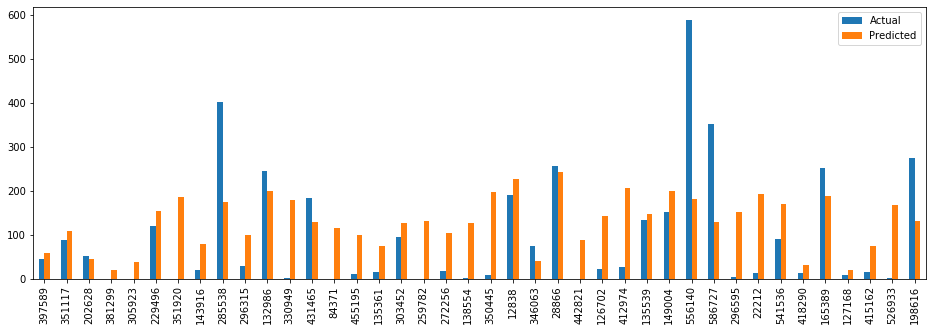

In [10]:
plot_real_vs_pred(y_val, reg_y_pred)

### Calculate Metrics: MAE, RMSE, R2, Correlation

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_metrics(y_real, y_pred):
    # MAE: same units as target variable. It is more robust to outliers
    MAE = mean_absolute_error(y_real, y_pred)

    # RMSE: same units as target variable
    RMSE = np.sqrt(mean_squared_error(y_real, y_pred))

    # Correlation
    R = np.corrcoef(y_real, y_pred)[0][1]

    # R^2
    R2 = r2_score(y_real, y_pred)

    print('MAE: ', MAE)
    print('RMSE: ', RMSE)
    print('R^2 (Coefficient of determination): ', R2)
    print('R (Correlation coefficient): ', R)
    
    return MAE, RMSE, R2, R

In [49]:
reg_metrics = get_metrics(y_val, reg_y_pred)

MAE:  110.11816891188789
RMSE:  150.91705611228386
R^2 (Coefficient of determination):  0.1092576219241913
R (Correlation coefficient):  0.33076886258728294


### K Nearest Neighbour Regressor (KNN)
Parameters:

   **k**: number of neighbors <br>
   **weight**: way to give more weight to points which are nearby and less weight to the points which are farther away.<br>

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Create an instance.
# Define number of neighbors.
# weights possible values: 'uniform', 'distance', [callable] user defined function
regk = KNeighborsRegressor(n_neighbors=2, weights = 'uniform')

# Train the data
regk.fit(X_train, y_train)

# Do predictions
regk_y_pred = regk.predict(X_val)

MAE:  26.965242281741975
RMSE:  50.84534576960667
R^2 (Coefficient of determination):  0.8988937797534982
R (Correlation coefficient):  0.9484065103130591


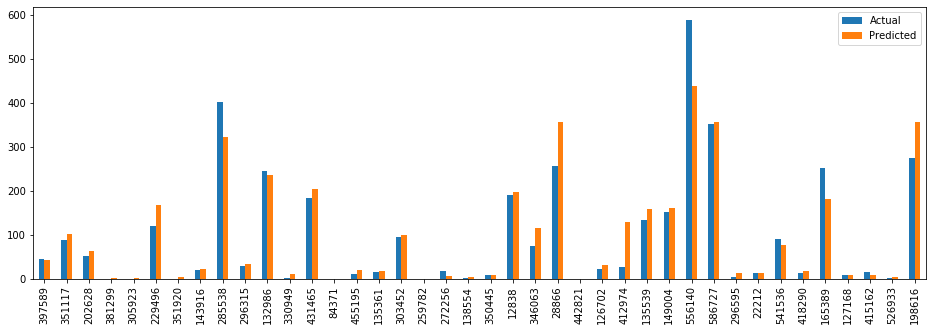

In [50]:
regk_metrics = get_metrics(y_val, regk_y_pred)
plot_real_vs_pred(y_val, regk_y_pred)

### Decision Tree Regressor

Testing parameters manually these are the best I have found:

``max_depth`` (number of splits): ``20``  
``min_samples_leaf`` (minimum number of samples for each split group): ``15``

It seems that above those values the model does not improve.

In [44]:
from sklearn.tree import DecisionTreeRegressor

# Create an instance.
regd = DecisionTreeRegressor (max_depth = 20,
                              min_samples_leaf=15)

# Train the data
regd.fit(X_train, y_train)

# Do predictions
regd_y_pred = regd.predict(X_val)

MAE:  18.318458361642637
RMSE:  36.555354969297895
R^2 (Coefficient of determination):  0.9477390288507453
R (Correlation coefficient):  0.9735328639692751


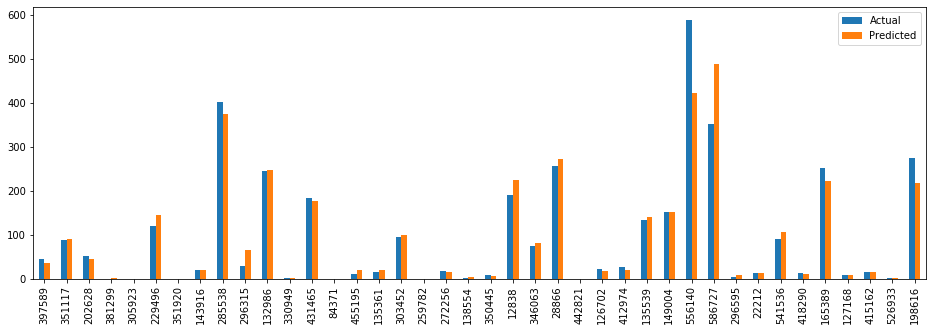

In [51]:
regd_metrics = get_metrics(y_val, regd_y_pred)
plot_real_vs_pred(y_val, regd_y_pred)

### Compare metrics

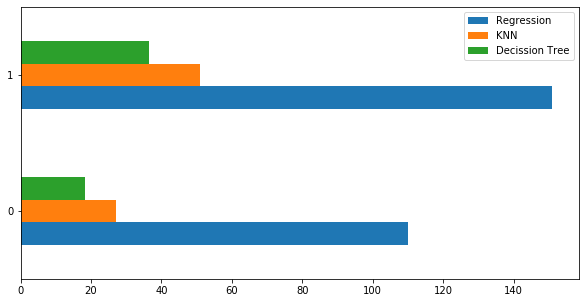

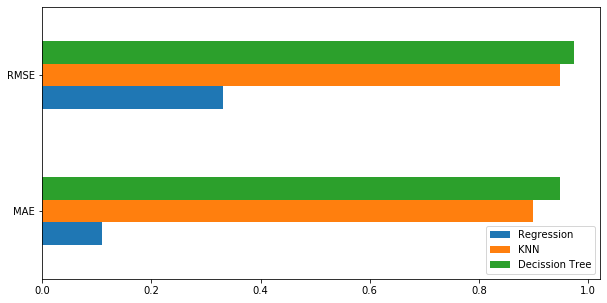

In [72]:
df_MAE_RMSE = pd.DataFrame({'Regression': [reg_metrics[0], reg_metrics[1]], \
                          'KNN': [regk_metrics[0], regk_metrics[1]], \
                          'Decission Tree': [regd_metrics[0], regd_metrics[1]]})

df_cor = pd.DataFrame({'Regression': [reg_metrics[2], reg_metrics[3]], \
                          'KNN': [regk_metrics[2], regk_metrics[3]], \
                          'Decission Tree': [regd_metrics[2], regd_metrics[3]]})

df_MAE_RMSE.plot(kind='barh', figsize=(10,5))
df_cor.plot(kind='barh', figsize=(10,5))
positions = (0,1)
labels = ('MAE', 'RMSE')
plt.yticks(positions, labels)
plt.show()

Probando ahora con GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

regk_grid = GridSearchCV(KNeighborsRegressor(),
                       param_grid={"n_neighbors":np.arange(2,5)},
                       cv = 2,
                       scoring = "neg_mean_absolute_error")

# Train the model with the dataset
regk_grid.fit(X_train,y_train)

# Do predictions
regk_grid_y_pred = regk_grid.predict(X_val)
print(regk_grid.score(X_train, y_train))
print(regk_grid.score(X_val, y_val))
print(regk_grid.score(X_test, y_test))
print('correlation: ', np.corrcoef(regk_grid_y_pred, y_val)[0][1])
%time

In [ ]:
regk_grid.best_params_

## MAE

Measures average magnitud of the errors without considering their direction (all errors in absolute value). It is intuitive to calculate, but you lose information related to the magnitud of the error.<br>
Units are the same as the target variable.<br>
Value range from 0 to infinite. Lower values are better.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Use against predictions
MAE = mean_absolute_error(reg.predict(X_val), y_val)
MAE

## MAPE

Similar to MAE but it measures the error in percentage.<br>
Lower values are better.<br>
MAPE is not in sklearn so I calculate it MANUALLY with pandas:

In [ ]:
MAPE = np.mean(np.abs(reg.predict(X_val) - y_val)/y_val)
MAPE

## RMSE

Measures average magnitud of errors.<br>
Units are the same as the target variable.<br>
Value range from 0 to infinite. Lower values are better.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Use against predictions (we have to calculate the squared root of MSE)
RMSE = np.sqrt(mean_absolute_error(reg.predict(X_val), y_val))
RMSE

In [ ]:
print('MEAN: ', y_val.mean())
print('MEDIAN: ', y_val.median())
print('MAE: ', MAE)
print('MAPE: ', MAPE)
print('RMSE: ', RMSE)

## Correlation

**There should be a strong correlation between predictions and real values.<br>
However, I get a very week correlation value of 0.31**

In [ ]:
np.corrcoef(reg.predict(X_val), y_val)[0][1]

## Bias
It is the average of errors (prediction values minus real values).<br>
Negative errors will compensate positive ones.

In [ ]:
bias = np.mean(reg.predict(X_val) - y_val)
bias

## Variance
Is the average of errors in predictions between two different data sets.

In [ ]:
# create table from X_train with same number of rows as X_val
# so it can be used to calculate the variance
X_train_for_variance = X_train.head(X_val.shape[0])

variance = np.mean(reg.predict(X_train_for_variance) - reg.predict(X_val))
variance

In [ ]:
# Merge X_train with predictions
combine = X_train.copy()
combine['pickups'] = y_train
combine['pickups Prediction'] = reg.predict(X_train)

combine.head(100)

In [ ]:
# Merge X_test with predictions
combine2 = X_test.copy()
combine2['pickups'] = y_test
combine2['pickups Prediction'] = reg.predict(X_test)

combine2.head(100)

In [ ]:
predictions = reg.predict(X_test)
X_test_g = X_test.groupby(['month', 'day','hour','LocationID']).sum()
X_test_g.head(100)

## Pack model with Pickle

In [ ]:
import pickle
pickle.dump(reg,open('./model_reg_01.pickle','wb'))